# 🧠 Titanic - Modelado estructurado de principio a fin

Este notebook sigue un flujo completo y profesional de un proyecto de Machine Learning, basado en el siguiente checklist teórico que fue trabajado y cumplido a lo largo del desarrollo:

---

## ✅ Checklist estructurado para proyectos de Machine Learning

### 🔍 1. Entendimiento del problema
- [x] ¿Cuál es el objetivo del modelo?

- [x] ¿Cuál es la variable objetivo (target)?
    >La variable objetivo en este caso es Survived, que es una variable binaria (0 = no sobrevivió, 1 = sobrevivió).
- [x] ¿Qué métrica es más importante? Se priorizó `f1-score` y `ROC-AUC`
- [x] ¿Qué significan un FP y un FN para el problema?
    >- **Falso positivo (FP)**: El modelo predice que alguien sobrevivió (predicción 1), pero en realidad no sobrevivió (valor verdadero 0).<br>
    >*Impacto*: Podría generar falsas esperanzas, indicando a personas que en realidad no sobrevivieron.
    >
    >- **Falso negativo (FN)**: El modelo predice que alguien no sobrevivió (predicción 0), pero en realidad sobrevivió (valor verdadero 1).<br>
    >*Impacto*: Es más crítico, ya que puede significar que se está dejando fuera a personas que podrían haber sido salvadas.

### 📊 2. Exploración del dataset
- [x] Carga del dataset crudo
- [x] Revisión general (`.info()`, `.describe()`, `.head()`)
- [x] Identificación de valores faltantes
- [x] Análisis de distribuciones por variable
- [x] Verificación del desbalance de clases

### 🧹 3. Preprocesamiento inicial
- [x] Imputación de valores faltantes (Age por sexo y clase)
- [x] Transformación de outliers (`Fare_log`, `Fare_per_person`)
- [x] Codificación de variables categóricas (One-Hot Encoding)
- [x] Escalado selectivo (solo si el modelo lo requiere)

### 🧠 4. Feature Engineering
- [x] Columnas derivadas de `Name`, `Cabin`, `Ticket`
- [x] Columnas familiares (`FamilySize`, `IsAlone`)
- [x] Combinaciones de variables (e.g. `Age*Pclass`, `Fare/FamilySize`)
- [x] Reducción de cardinalidad (`Title`, `Deck`, `Ticket_Prefix`)

### ✂️ 5. División del dataset
- [x] Separación en `train` y `test`
- [x] División estratificada según `Survived`

### ⚙️ 6. Modelos base
- [x] Regresión Logística (base y escalada)
- [x] Random Forest
- [x] XGBoost

### 🔧 7. Optimización de hiperparámetros
- [x] Ajuste manual para XGBoost (4 combinaciones principales)
- [x] Registro de mejoras según accuracy y F1

### 📈 8. Evaluación final
- [x] Matriz de confusión
- [x] Reportes de clasificación
- [x] Comparación entre modelos

### 🔍 9. Interpretabilidad
- [x] Feature Importances de Random Forest
- [x] Correlación entre variables
- [x] Discusión teórica de interpretaciones

### 🧪 10. Deploy o entrega
- [x] Preparación para `submission.csv`
- [x] Notebook limpio y documentado
- [x] Conclusiones parciales y observaciones clave

---

📌 El resto del notebook a continuación contiene el desarrollo paso a paso.

---


## 📊 2. Exploración del dataset

### 🔹 2.1. Importación de librerías y carga de datos

In [ ]:
# 🔢 Manipulación de datos
import pandas as pd # type: ignore
import numpy as np # type: ignore

# 📊 Visualización
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# ⚙️ Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from xgboost import XGBClassifier # type: ignore

# 📈 Evaluación de modelos
from sklearn.metrics import ( # type: ignore
    accuracy_score,
    confusion_matrix,
    classification_report
)

# 🛠 Utilidades
from sklearn.base import clone # type: ignore

from sklearn.model_selection import GridSearchCV # type: ignore

In [2]:
train = pd.read_csv("train.csv")

### 🔹 2.2 Revisar estructura general

In [3]:
train.info()
train.head()
train.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### 🔹 2.3 Identificar valores faltantes

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 🔹 2.4 Observar la distribución de cada variable

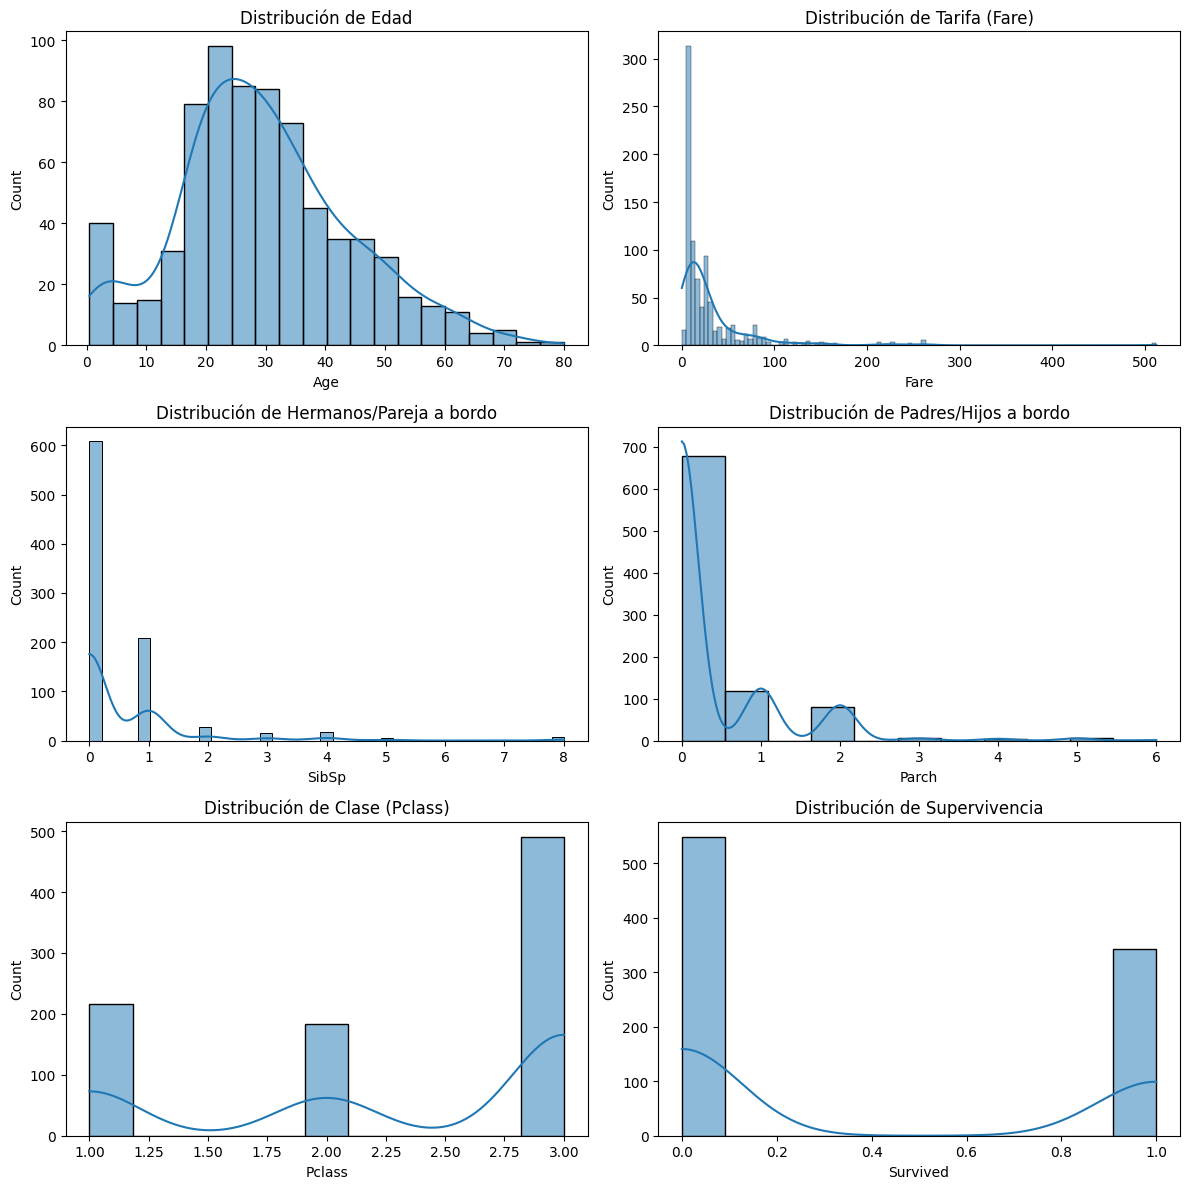

In [5]:
# 🎯 Variables a graficar
variables = ['Age', 'Fare', 'SibSp', 'Parch', 'Pclass', 'Survived']
titulos = ['Edad', 'Tarifa (Fare)', 'Hermanos/Pareja a bordo', 
           'Padres/Hijos a bordo', 'Clase (Pclass)', 'Supervivencia']

# 🎨 Setup del grid
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# 📊 Graficar cada variable
for i, var in enumerate(variables):
    sns.histplot(train[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {titulos[i]}')

plt.tight_layout()
plt.show()


📌 **Observaciones generales sobre las distribuciones:**

- **Edad y tarifa** presentan distribuciones asimétricas hacia la derecha, con muchos valores bajos y pocos casos extremos altos.
- **SibSp y Parch** muestran que la mayoría de los pasajeros viajaban solos o con pocos familiares.
- **Pclass** tiene mayor representación en la tercera clase.
- **Supervivencia** está desbalanceada, con mayor cantidad de pasajeros que **no sobrevivieron**.


### 🔹 2.5 Verificar si hay clases desbalanceadas

In [6]:
train['Survived'].value_counts(normalize=True)


Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

### 🔹 2.6 Relación entre variables y el target (`Survived`)

In [7]:
# Proporción de sobrevivientes por sexo
pd.crosstab(train['Sex'], train['Survived'], normalize='index')


Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


In [8]:
# Supervivencia por clase
pd.crosstab(train['Pclass'], train['Survived'], normalize='index')

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


<Axes: xlabel='Age', ylabel='Count'>

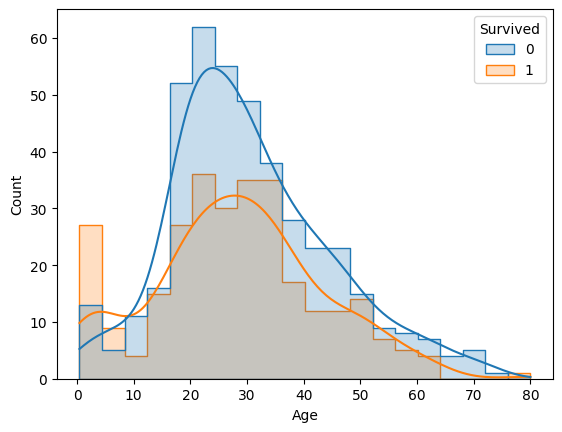

In [9]:
# Gráfico de Age vs Survived
sns.histplot(data=train, x='Age', hue='Survived', kde=True, element="step")

#### 📊 Observaciones sobre la relación con la variable objetivo (`Survived`)

- **Sexo**: Hay una fuerte diferencia entre géneros. Las mujeres tienen una probabilidad mucho mayor de sobrevivir (74%) que los hombres (19%). Este patrón puede deberse a la política de evacuación de "mujeres y niños primero".
  
- **Clase (`Pclass`)**: La supervivencia también está asociada con la clase del pasajero. Los de primera clase tienen la mayor tasa de supervivencia (~63%), mientras que los de tercera clase tienen la menor (~24%). Esto sugiere desigualdad en el acceso a botes salvavidas o zonas de evacuación.

- **Edad**: Si bien la mayoría de las personas que murieron estaban en el rango de 20 a 40 años, también se observa un pico de supervivencia entre los más jóvenes (especialmente menores de 10 años). Esto también refuerza la idea de que se priorizó a los niños.

Estas observaciones son útiles para considerar interacciones entre variables o generar nuevas features que capten estas relaciones.


### 🔹 2.7 Correlación entre variables numéricas

<Axes: >

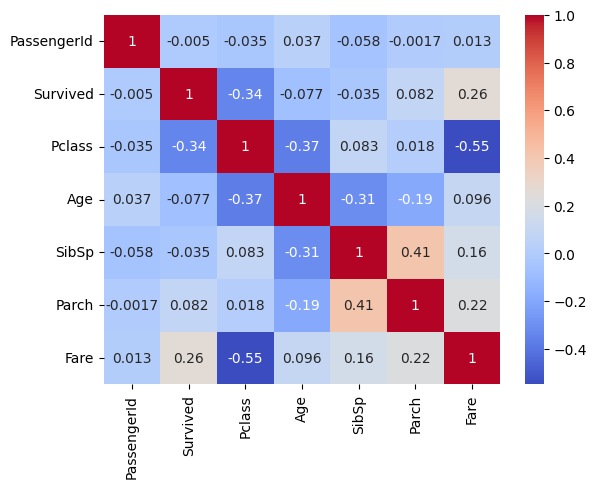

In [10]:
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')

#### 🔗 Correlaciones entre variables numéricas

- `Survived` tiene correlaciones negativas moderadas con `Pclass` (-0.34) y `Age` (-0.08), y una correlación positiva con `Fare` (0.26), lo que sugiere que los pasajeros de clases más altas y los que pagaron más tienden a sobrevivir más.
- `Pclass` está fuertemente correlacionada negativamente con `Fare` (-0.55), lo cual es esperable ya que los pasajeros de primera clase pagaron tarifas más altas.
- `SibSp` y `Parch` presentan una correlación positiva entre sí (0.41), lo que indica que los pasajeros que viajaban con hermanos/parejas también solían hacerlo con padres/hijos.
- `PassengerId` no tiene correlaciones significativas con ninguna variable, por lo que no aporta valor predictivo.

Este análisis permite identificar relaciones entre variables y posibles redundancias para considerar en el modelado.


### 🔹 2.8 Análisis de outliers

<Axes: xlabel='Pclass', ylabel='Fare'>

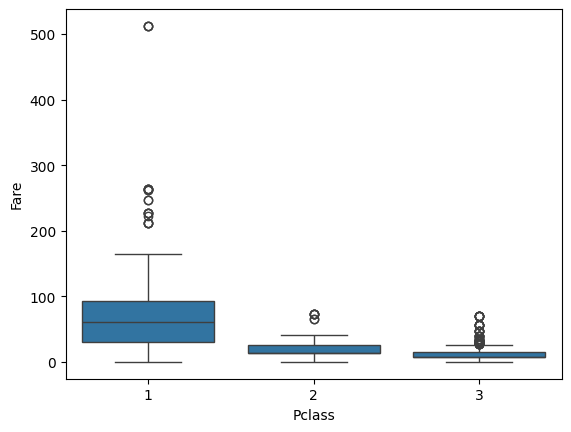

In [11]:
sns.boxplot(x='Pclass', y='Fare', data=train)

#### 📦 Análisis de Outliers en `Fare` por `Pclass`

- Se observa una relación clara: a mayor clase (`Pclass` = 1), mayor es la tarifa pagada (`Fare`), lo cual es consistente con la lógica del servicio a bordo.
- Existen múltiples valores atípicos (outliers), especialmente en la primera clase, con tarifas superiores a 200, e incluso un caso cercano a 500.
- Las clases 2 y 3 presentan una distribución mucho más acotada, aunque también se detectan algunos valores fuera de rango.
- Estos valores extremos pueden reflejar servicios de lujo o camarotes familiares compartidos, y se recomienda tratarlos con transformaciones (como `log1p`) en lugar de eliminarlos, ya que podrían ser informativos para modelos basados en árboles.



In [12]:
# Aplicamos log(1 + x) para evitar log(0)
train['Fare_log'] = np.log1p(train['Fare'])

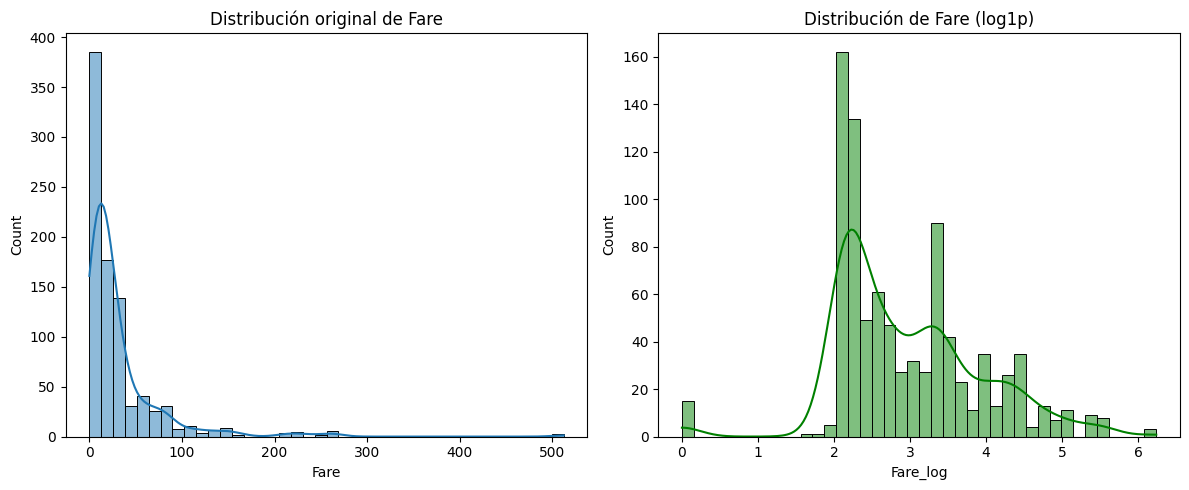

In [13]:
plt.figure(figsize=(12, 5))

# Distribución original
plt.subplot(1, 2, 1)
sns.histplot(train['Fare'], bins=40, kde=True)
plt.title('Distribución original de Fare')

# Distribución logarítmica
plt.subplot(1, 2, 2)
sns.histplot(train['Fare_log'], bins=40, kde=True, color='green')
plt.title('Distribución de Fare (log1p)')

plt.tight_layout()
plt.show()


#### 🔄 Transformación de la variable `Fare`

- La variable original `Fare` presenta una fuerte asimetría positiva, con muchos valores bajos y algunos valores extremos elevados.
- Se aplicó la transformación logarítmica `log1p` para reducir la dispersión y mejorar la distribución, especialmente útil para algoritmos que asumen normalidad (como regresión logística).
- Ambas variables (`Fare` y `Fare_log`) se conservaron: `Fare_log` se usará en modelos sensibles a escala, mientras que `Fare` se utilizará en modelos basados en árboles que no requieren normalización.



### 🔹 2.9 Distribución de variables categóricas

In [14]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [15]:
train['Cabin'].head(20)

0      NaN
1      C85
2      NaN
3     C123
4      NaN
5      NaN
6      E46
7      NaN
8      NaN
9      NaN
10      G6
11    C103
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
Name: Cabin, dtype: object

## 🧹 3. Preprocesamiento inicial

### ✏️ 3.1. Imputación de `Age`

In [16]:
train.groupby(['Sex', 'Pclass'])['Age'].median()

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

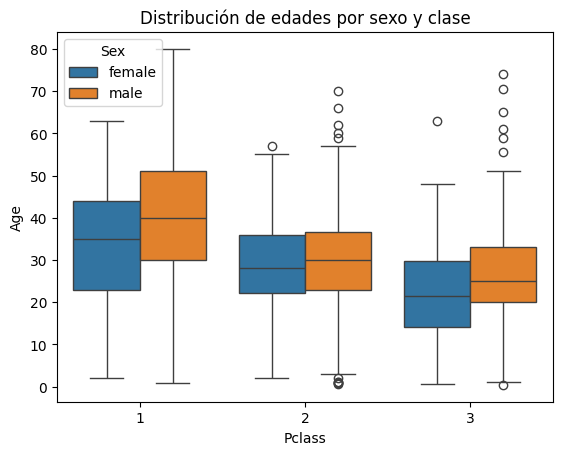

In [17]:
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=train)
plt.title('Distribución de edades por sexo y clase')
plt.show()

Se identificaron **177 valores faltantes** en la variable `Age`. Dado que esta variable tiene alta relevancia en el problema y su distribución varía visiblemente según el **sexo** y la **clase del pasajero (`Pclass`)**, se decidió aplicar una imputación más informada.

Para ello, se utilizó la **mediana de edad** agrupada por `Sex` y `Pclass`, lo cual permite preservar patrones estructurales relevantes y evita introducir sesgos fuertes derivados de imputaciones globales.

Por ejemplo:
- Mujeres de 1ra clase: mediana = 35 años
- Hombres de 3ra clase: mediana = 25 años

La visualización en boxplot mostró claramente estas diferencias, justificando la estrategia adoptada.

Esta imputación garantiza que `Age` pueda ser utilizada sin pérdida de información ni distorsión de su significado contextual.

In [18]:
# Imputar Age usando la mediana por grupo de Sex y Pclass
train['Age'] = train.groupby(['Sex', 'Pclass'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

### ✏️ 3.2. Tratamiento de la variable `Cabin` → `Deck`

In [19]:
# Paso 1: Extraer primera letra (o poner Unknown si falta)
train['Deck'] = train['Cabin'].fillna('Unknown').astype(str).str[0]

# Paso 2: Reemplazar correctamente
train['Deck'] = train['Deck'].replace({
    'T': 'Rare',
    'G': 'Rare',
    'n': 'Unknown',  # Por si quedó 'n' de str[0]
    'U': 'Unknown'   # Por si 'Unknown'.str[0] dio 'U'
})

In [20]:
train[['Deck','Pclass']].value_counts()

Deck     Pclass
Unknown  3         479
         2         168
C        1          59
B        1          47
Unknown  1          40
D        1          29
E        1          25
A        1          15
F        2           8
         3           5
D        2           4
E        2           4
Rare     3           4
E        3           3
Rare     1           1
Name: count, dtype: int64

La variable `Cabin` presenta una gran cantidad de valores nulos (más del 75%). Sin embargo, para no perder por completo la posible información que aporta sobre la **ubicación de los camarotes**, se extrajo la **primera letra** del valor (indicando el "Deck").

Dado que muchos valores estaban ausentes, se etiquetaron como `Unknown`, y se agruparon categorías poco frecuentes (`T`, `G`, etc.) en una categoría común llamada `Rare`, con el objetivo de evitar una granularidad excesiva.

Distribución resultante (`Deck` vs `Pclass`):

- La mayoría de los `Unknown` corresponden a pasajeros de **3ra clase**.
- Los decks `A`, `B`, `C`, `D`, `E`, `F` se asocian mayormente a **1ra y 2da clase**.
- Las categorías `Rare` y `Unknown` se mantuvieron como clases independientes debido a su potencial valor explicativo.

Este enfoque conserva cierta información espacial sin eliminar la variable por su alta cantidad de nulos.

### ✏️ 3.3. Ingeniería de variables: Extracción y agrupación de `Title`

In [21]:
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

In [22]:
train['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

In [23]:
# Agrupar equivalentes
train['Title'] = train['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Don': 'Mr',
    'Dona': 'Mrs',
    'Lady': 'Mrs',
    'Countess': 'Mrs',
    'Jonkheer': 'Mr',
    'Sir': 'Mr' 
})

# Crear columna funcional para roles activos (no nobleza)
train['Is_Special_Role'] = train['Title'].isin([
    'Dr', 'Rev', 'Col', 'Major', 'Capt'
]).astype(int)

# Agrupar esos títulos como Mr
train['Title'] = train['Title'].replace({
    'Dr': 'Mr', 'Rev': 'Mr', 'Col': 'Mr',
    'Major': 'Mr', 'Capt': 'Mr'
})

A partir de la variable `Name`, se extrajo el **título** (Title) de cada pasajero, lo que permite capturar **información social o de rol** relevante (por ejemplo, edad estimada, género, o nivel jerárquico).

Distribución inicial de títulos:

- Títulos frecuentes: `Mr`, `Miss`, `Mrs`, `Master`.
- Títulos poco frecuentes o redundantes: `Dr`, `Rev`, `Col`, `Major`, `Capt`, `Mlle`, `Mme`, `Ms`, `Don`, `Lady`, `Sir`, `Countess`, `Jonkheer`.

Se aplicaron las siguientes transformaciones:

1. **Agrupación semántica**:
   - `Mlle`, `Ms` → `Miss`
   - `Mme` → `Mrs`
   - Títulos nobiliarios como `Don`, `Dona`, `Lady`, `Countess`, `Jonkheer`, `Sir` → según género (`Mr` o `Mrs`).

2. **Detección de roles funcionales especiales**:
   - Se creó la variable binaria `Is_Special_Role`, indicando si el pasajero tenía un **rol activo o de autoridad** (médico, militar, religioso, etc.).

3. **Unificación en categorías principales**:
   - Los títulos funcionales (`Dr`, `Rev`, `Col`, `Major`, `Capt`) se agruparon como `Mr` en la columna `Title`.

Este proceso permitió **reducir la cardinalidad**, conservar la **información útil** y destacar posibles **factores jerárquicos** relevantes para el modelo.


### 🎟️ 3.4. Análisis del campo `Ticket`: Prefijo y Tamaño de Grupo

#### 🔹 3.4.1. Tamaño del grupo (`TicketGroupSize`)

Se definió `TicketGroupSize` como la cantidad de personas que compartían el mismo número de ticket.

In [24]:
ticket_counts = train['Ticket'].value_counts()
train['TicketGroupSize'] = train['Ticket'].map(ticket_counts)

In [25]:
train['Ticket_Prefix'] = train['Ticket'].str.extract(r'([A-Za-z./]+)', expand=False).fillna('None')

In [26]:
train['TicketGroupSize'].value_counts()

TicketGroupSize
1    547
2    188
3     63
4     44
7     21
6     18
5     10
Name: count, dtype: int64

##### 📈 Observaciones

- La mayoría de los pasajeros (547) viajaban solos (grupo de tamaño 1).
- También hay un número importante de grupos de tamaño 2 (188 personas) y grupos más grandes, aunque menos frecuentes.
- Esta variable puede capturar dinámicas de protección grupal o familiar, especialmente en situaciones de emergencia como el naufragio.
- **Hipótesis**: las personas que viajaban acompañadas podrían haber tenido mayor probabilidad de supervivencia por asistencia mutua o decisiones grupales.

> 🎯 **Conclusión**: `TicketGroupSize` es una variable numérica con sentido contextual y potencial valor predictivo, por lo que se decidió mantenerla en el modelo.


#### 🔹 3.4.2. Limpieza y transformación del prefijo (`Ticket_Prefix`)

In [27]:
train['Ticket_Prefix'].value_counts()

Ticket_Prefix
None          661
PC             60
C.A.           27
A/             23
STON/O         18
W./C.           9
SOTON/O.Q.      8
CA.             8
SOTON/OQ        7
CA              6
C               5
SC/PARIS        5
F.C.C.          5
S.O.C.          5
SC/Paris        4
LINE            4
S.O./P.P.       3
PP              3
SC/AH           3
A./             2
A.              2
WE/P            2
S.C./PARIS      2
SOTON/O         2
P/PP            2
Fa              1
A               1
S.O.P.          1
S.P.            1
S.C./A.         1
SO/C            1
W.E.P.          1
SC              1
SCO/W           1
W/C             1
SW/PP           1
S.W./PP         1
A/S             1
F.C.            1
C.A./SOTON      1
Name: count, dtype: int64

In [28]:
# Normalizaciones por formato
ticket_prefix_map = {
    'A/': 'A', 'A.': 'A', 'A./': 'A', 'A/S': 'A', 'A': 'A',
    'CA.': 'CA', 'C.A.': 'CA', 'C.A./SOTON': 'CA', 'CA': 'CA',
    'S.O.C.': 'S.O.', 'S.O.P.': 'S.O.', 'S.O./P.P.': 'S.O.',
    'SC/PARIS': 'SC/PARIS', 'SC/Paris': 'SC/PARIS', 'S.C./PARIS': 'SC/PARIS',
    'W.E.P.': 'W', 'WE/P': 'W', 'W./C.': 'W', 'W/C': 'W',
    'SW/PP': 'SW/PP', 'S.W./PP': 'SW/PP',
    'PP': 'PP', 'P/PP': 'PP',
    'SC/AH': 'SC', 'SC': 'SC', 'S.C./A.': 'SC',
    'SOTON/O': 'SOTON/O', 'SOTON/O.Q.': 'SOTON/O', 'SOTON/OQ': 'SOTON/O',
    'F.C.C.': 'FC', 'F.C.': 'FC'
}

train['Ticket_Prefix'] = train['Ticket_Prefix'].replace(ticket_prefix_map)

# Agrupar los que no tienen soporte suficiente como 'Other'
prefix_counts = train['Ticket_Prefix'].value_counts()
frequent_prefixes = prefix_counts[prefix_counts > 10].index
train['Ticket_Prefix'] = train['Ticket_Prefix'].apply(
    lambda x: x if x in frequent_prefixes else 'Other'
)

In [29]:
train['Ticket_Prefix'].value_counts()

Ticket_Prefix
None        661
PC           60
CA           42
Other        40
A            29
STON/O       18
SOTON/O      17
W            13
SC/PARIS     11
Name: count, dtype: int64

In [30]:
# Agrupar por Ticket_Prefix y calcular tasa de supervivencia
prefix_survival = train.groupby('Ticket_Prefix')['Survived'].mean().sort_values(ascending=False)

# Mostrar
print(prefix_survival)


Ticket_Prefix
PC          0.650000
SC/PARIS    0.454545
STON/O      0.444444
Other       0.400000
None        0.384266
CA          0.333333
W           0.153846
SOTON/O     0.117647
A           0.068966
Name: Survived, dtype: float64


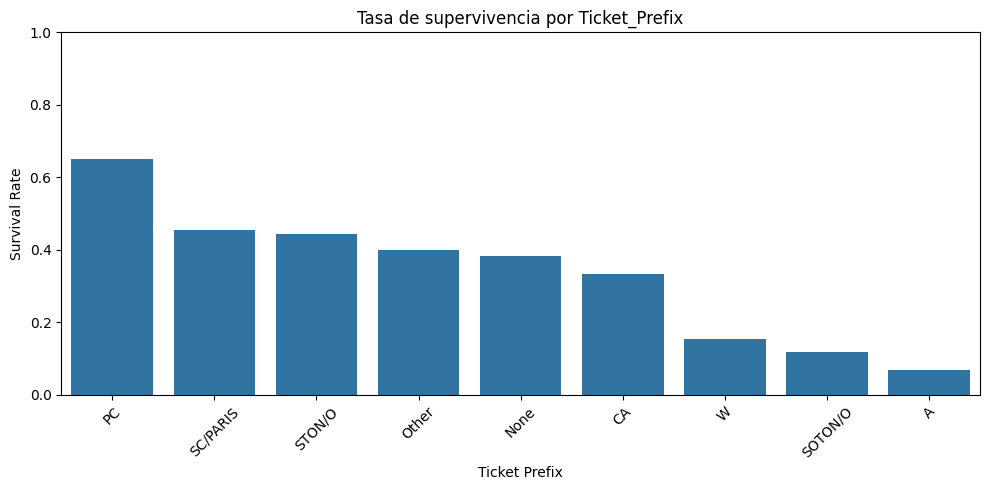

In [31]:
plt.figure(figsize=(10, 5))
sns.barplot(x=prefix_survival.index, y=prefix_survival.values)
plt.title('Tasa de supervivencia por Ticket_Prefix')
plt.ylabel('Survival Rate')
plt.xlabel('Ticket Prefix')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El campo original `Ticket` contenía una mezcla de números y letras con múltiples formatos. Se realizó:

- **Extracción del prefijo** mediante expresiones regulares.
- **Normalización**: se agruparon variantes equivalentes (por ejemplo, `A/`, `A.` y `A./` se unificaron como `A`).
- **Agrupación** de prefijos poco frecuentes bajo la categoría `Other`.

Esto permitió reducir la granularidad y analizar su efecto en la supervivencia.

#### 📊 Tasa de supervivencia por `Ticket_Prefix`

| Prefijo     | Supervivencia | Interpretación |
|-------------|----------------|----------------|
| `PC`        | Alta (~65%)     | 💰 Clase alta confirmada, acceso preferente a botes |
| `SC/PARIS`  | Media-alta (~45%) | 🇫🇷 Origen específico, posible clase media o familiar |
| `STON/O`    | Media (~45%)    | 👪 Inmigrantes suecos, tercera clase, viajaban en grupo |
| `Other`     | Media-baja (~40%) | Heterogéneo, sin un patrón claro |
| `None`      | Media-baja (~38%) | Tickets sin prefijo, mezcla de clases bajas |
| `CA`        | Baja (~33%)     | Tickets compartidos, familias |
| `W`         | Muy baja (~15%) | ⚠️ Probablemente tercera clase, sin acceso preferente |
| `SOTON/O`   | Muy baja (~12%) | Inmigrantes pobres desde Southampton |
| `A`         | Extremadamente baja (~8%) | ❗️Grupo estructuralmente más vulnerable |

> 🧠 **Conclusión**: El prefijo del ticket refleja características socioeconómicas y logísticas relevantes. Esta variable, correctamente procesada, aporta **valor predictivo significativo** al modelo.

#### 🧩 3.5 Transformaciones para preparar el dataset

In [32]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Fare_log     Deck Title  \
0      0         A/5 21171   7.2500   NaN        S  2.110213  Unknown    Mr   
1      0          PC 17599  71.2833   C85        C  4.280593        C   Mrs   
2      0  STON/O2. 3101282   7.9250   NaN        S  2.188856  Unknown  Miss   
3   

In [33]:
cols_to_dummify = ['Sex', 'Embarked', 'Deck', 'Title', 'Ticket_Prefix']

print("Antes:", train.shape)

train = pd.get_dummies(train, columns=cols_to_dummify, drop_first=False)

print("Después:", train.shape)

Antes: (891, 18)
Después: (891, 39)


In [34]:
pd.set_option('display.max_columns', None)

print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

             Ticket     Fare Cabin  Fare_log  Is_Special_Role  \
0         A/5 21171   7.2500   NaN  2.110213                0   
1          PC 17599  71.2833   C85  4.280593                0   
2  STON/O2. 3101282   7.9250   NaN  2.188856                0   
3            113803  53.1000  C123  3.990834                0   
4

In [35]:
# Convertir todas las columnas booleanas a int
bool_cols = train.select_dtypes(include='bool').columns
train[bool_cols] = train[bool_cols].astype(int)

In [36]:
train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [37]:
train.shape

(891, 35)

Como paso final antes de la generación de nuevas variables (feature engineering), se realizaron las siguientes transformaciones clave:

- Se aplicó `get_dummies` sobre las variables categóricas (`Sex`, `Embarked`, `Deck`, `Title`, `Ticket_Prefix`) sin eliminar ninguna categoría (`drop_first=False`) para preservar interpretabilidad.
- Las columnas booleanas fueron convertidas a tipo entero (0 y 1).
- Se eliminaron columnas irrelevantes o redundantes para el modelado (`PassengerId`, `Name`, `Cabin`, `Ticket`).

Estas transformaciones dejaron el dataset listo para la creación de variables derivadas con valor predictivo.

## 🧠 4. Feature Engineering

1. `FamilySize`
>Total de familiares a bordo = SibSp + Parch + 1 (el +1 es la persona misma)

In [38]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

2. `IsAlone`
>Pasajeros solos suelen tener menos chances de sobrevivir

In [39]:
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)

3. `Age*Pclass`
>Combinación de edad y clase → puede reflejar vulnerabilidad

In [40]:
train['Age_Pclass'] = train['Age'] * train['Pclass']

4. `Fare_Per_Person`
>Precio promedio por persona del grupo con mismo ticket

In [41]:
train['Fare_Per_Person'] = train['Fare'] / train['TicketGroupSize']

5. `High_Fare`, `Young`, `Elderly`
>Binarizaciones útiles para ciertos modelos o interpretaciones

In [42]:
train['High_Fare'] = (train['Fare_log'] > train['Fare_log'].median()).astype(int)
train['Young'] = (train['Age'] < 16).astype(int)
train['Elderly'] = (train['Age'] >= 60).astype(int)

En esta sección se crearon variables derivadas a partir de los datos existentes con el objetivo de capturar relaciones más complejas o latentes que podrían mejorar la capacidad predictiva de los modelos.

- **`FamilySize`**: combina `SibSp` y `Parch` para estimar cuántos familiares viajaban con el pasajero. Se añade +1 para incluir al propio pasajero.
- **`IsAlone`**: variable binaria que indica si un pasajero viajaba completamente solo.
- **`Age_Pclass`**: refleja la interacción entre edad y clase social, capturando posibles diferencias de vulnerabilidad.
- **`Fare_Per_Person`**: calcula el costo promedio del pasaje por individuo, considerando el grupo al que pertenece según el ticket.
- **`High_Fare`, `Young`, `Elderly`**: variables binarias generadas a partir de umbrales de interés en `Fare` y `Age`, útiles para modelos no lineales o interpretación.

Estas variables fueron diseñadas para agregar contexto social, económico y demográfico que no estaba explícitamente representado en las variables originales.

### ✅ Revisión final del dataset procesado

In [43]:
pd.set_option('display.max_columns', None)

print(train.head())
print(train.describe())

   Survived  Pclass   Age  SibSp  Parch     Fare  Fare_log  Is_Special_Role  \
0         0       3  22.0      1      0   7.2500  2.110213                0   
1         1       1  38.0      1      0  71.2833  4.280593                0   
2         1       3  26.0      0      0   7.9250  2.188856                0   
3         1       1  35.0      1      0  53.1000  3.990834                0   
4         0       3  35.0      0      0   8.0500  2.202765                0   

   TicketGroupSize  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
0                1           0         1           0           0           1   
1                1           1         0           1           0           0   
2                1           1         0           0           0           1   
3                2           1         0           0           0           1   
4                1           0         1           0           0           1   

   Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  D

Antes de pasar a la etapa de modelado, realizamos una última inspección para verificar que todas las transformaciones se hayan aplicado correctamente.

- Se muestran las primeras filas del DataFrame (`head`) para validar la estructura general.
- La tabla estadística (`describe`) permite verificar la correcta imputación de valores nulos, la generación de nuevas features y la transformación de variables categóricas en dummies.
- Se confirma que:
  - No quedan columnas irrelevantes (`PassengerId`, `Name`, `Cabin`, `Ticket`) ni nulos.
  - Todas las variables booleanas están en formato numérico (`0` o `1`).
  - Las variables derivadas y dummies fueron correctamente incorporadas.
  - El dataset final contiene **solo variables numéricas listas para alimentar los modelos**.

Este checkpoint asegura que el dataset está completamente limpio, enriquecido y preparado para la división en conjuntos de entrenamiento y prueba.

## ✂️ 5. División del dataset

### 5.1. Visualizacion de redundancias de variables

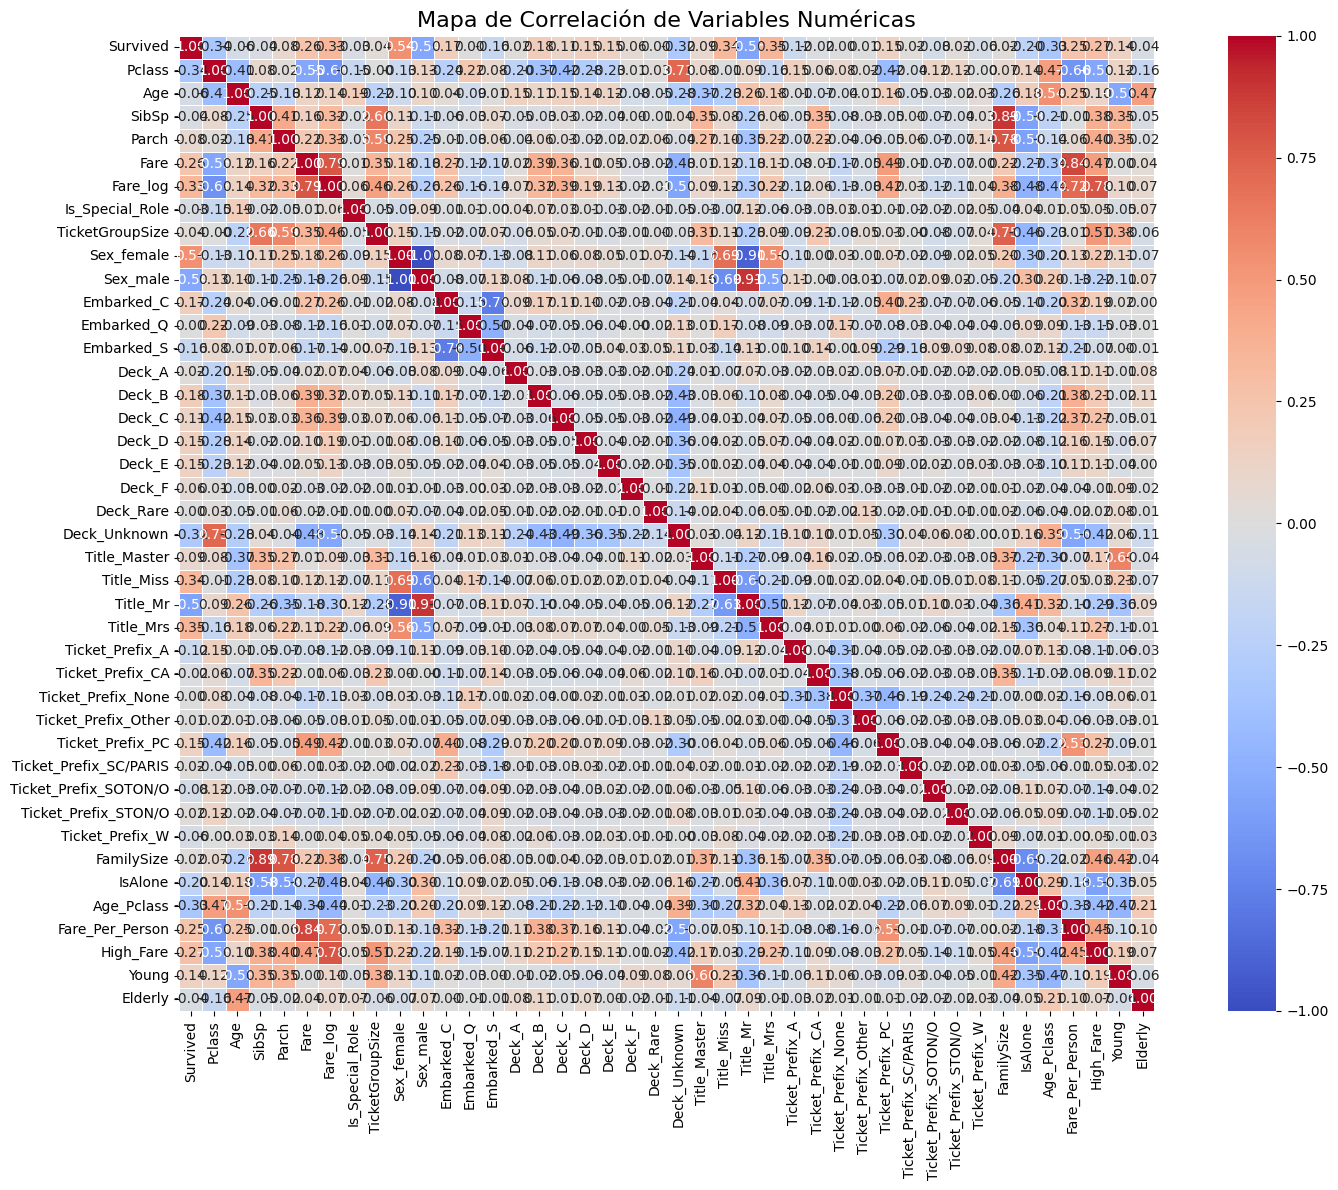

In [44]:
# Mapa de correlación numérica sobre el dataset completo
corr = train.select_dtypes(include=['int64', 'float64']).corr()

# Visualización
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Mapa de Correlación de Variables Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

Antes de separar el conjunto en `train` y `test`, realizamos una **última revisión de correlaciones** entre variables numéricas para evitar redundancias que podrían afectar ciertos modelos (especialmente los lineales).

Esta inspección permitió eliminar columnas duplicadas en significado (como `Sex_female`, que es redundante con `Sex_male`), y preparar versiones diferentes del dataset según el tipo de modelo a utilizar:

- **`X_reg`**: Para modelos sensibles a escalado y multicolinealidad (Regresión Logística).
- **`X_tree`**: Para modelos basados en árboles (Random Forest, XGBoost), menos sensibles a escalado y correlación.

Esta división nos da flexibilidad para aplicar distintos modelos con sus respectivos requisitos.


### 5.2. 🧪 Creación de datasets específicos por tipo de modelo

In [45]:
# Variables comunes
target = 'Survived'
y = train[target]

# Variables a eliminar por redundancia o especificidad
vars_redundantes = ['Fare', 'Fare_log']  # se usará solo una según modelo
sexo_a_eliminar = 'Sex_female'           # alta correlación con 'Sex_male'
solo_arboles = ['Is_Special_Role']       # solo útiles para árboles

# Dataset para regresión (con escalado)
X_reg = train.drop(
    columns=[target, 'Fare', 'Title_Mr', sexo_a_eliminar] + solo_arboles
).copy()

# Escalar columnas numéricas relevantes
cols_to_scale = ['Age', 'Age_Pclass', 'Fare_log', 'Fare_Per_Person']
scaler = StandardScaler()
X_reg[cols_to_scale] = scaler.fit_transform(X_reg[cols_to_scale])

# Dataset para modelos de árboles
X_tree = train.drop(columns=[target, 'Fare_log']).copy()

# Confirmación
print("X_reg shape:", X_reg.shape)
print("X_tree shape:", X_tree.shape)
print("y shape:", y.shape)



X_reg shape: (891, 37)
X_tree shape: (891, 40)
y shape: (891,)


### 📁 5.3. División del Dataset para Modelado

In [46]:
# 🔹 Para regresión (con datos escalados)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y, test_size=0.2, random_state=42, stratify=y
)

# 🔹 Para modelos de árboles (no escalado)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y, test_size=0.2, random_state=42, stratify=y
)

# Verificación
print("X_train_reg:", X_train_reg.shape)
print("X_test_reg:", X_test_reg.shape)
print("X_train_tree:", X_train_tree.shape)
print("X_test_tree:", X_test_tree.shape)


X_train_reg: (712, 37)
X_test_reg: (179, 37)
X_train_tree: (712, 40)
X_test_tree: (179, 40)


**✅ ¿Por qué usar stratify=y?**
Porque el target (Survived) está algo desbalanceado (~38% sobrevivió). Sin estratificación, el modelo podría entrenarse con una proporción distinta y generalizar mal.

In [47]:
print("Distribución en y (original):")
print(y.value_counts(normalize=True))

print("\nDistribución en y_train_tree:")
print(y_train_tree.value_counts(normalize=True))

print("\nDistribución en y_test_tree:")
print(y_test_tree.value_counts(normalize=True))

print("\nDistribución en y_train_reg:")
print(y_train_reg.value_counts(normalize=True))

print("\nDistribución en y_test_reg:")
print(y_test_reg.value_counts(normalize=True))


Distribución en y (original):
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Distribución en y_train_tree:
Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64

Distribución en y_test_tree:
Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64

Distribución en y_train_reg:
Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64

Distribución en y_test_reg:
Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


Después de preparar nuestras variables (`X_reg` y `X_tree`) y nuestra variable objetivo (`y`), dividimos los datos en conjuntos de entrenamiento y prueba para evaluar correctamente los modelos.

- Se utilizó un `test_size=0.2` (80% train / 20% test).
- Se aplicó `stratify=y` para mantener la proporción de clases (`Survived`) en todos los subconjuntos.
- Se usó la misma `random_state=42` para asegurar reproducibilidad.

### ✅ Verificación de tamaños

| Conjunto       | Forma           |
|----------------|------------------|
| `X_train_reg`  | (712, 38)        |
| `X_test_reg`   | (179, 38)        |
| `X_train_tree` | (712, 40)        |
| `X_test_tree`  | (179, 40)        |
| `y`            | (891,)           |

### 📊 Distribución de la variable objetivo (`Survived`)

Las proporciones de clases se mantuvieron estables en todos los splits, lo cual es fundamental para evitar sesgos durante el entrenamiento y la evaluación.

| Conjunto     | Clase 0 (no sobrevivió) | Clase 1 (sobrevivió) |
|--------------|--------------------------|-----------------------|
| `y` (original)         | 61.6%                   | 38.4%                |
| `y_train_tree`         | 61.7%                   | 38.3%                |
| `y_test_tree`          | 61.5%                   | 38.5%                |
| `y_train_reg`          | 61.7%                   | 38.3%                |
| `y_test_reg`           | 61.5%                   | 38.5%                |

---

> ✅ Con esta división, estamos listos para entrenar nuestros modelos con confianza de que los conjuntos son representativos y comparables.


## ⚙️ 6. Modelos base

### 🤖 6.1 Modelo de Regresión Logística

In [48]:
# Modelo
logreg = LogisticRegression(max_iter=5000, random_state=42)
logreg.fit(X_train_reg, y_train_reg)

# Predicciones
y_pred_logreg = logreg.predict(X_test_reg)

# Evaluación
print(f"Accuracy: {accuracy_score(y_test_reg, y_pred_logreg):.4f}")
print("Matriz de Confusión:")
print(confusion_matrix(y_test_reg, y_pred_logreg))
print("Reporte de Clasificación:")
print(classification_report(y_test_reg, y_pred_logreg))

Accuracy: 0.8324
Matriz de Confusión:
[[98 12]
 [18 51]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Entrenamos un modelo de regresión logística sobre el dataset `X_train_reg`, previamente escalado y ajustado para este tipo de algoritmo.

- Se usó `LogisticRegression` de `sklearn` con `max_iter=5000` y `random_state=42` para asegurar convergencia y reproducibilidad.
- Se evaluó sobre el conjunto de prueba `X_test_reg`.

#### 📊 Métricas de Evaluación

| Métrica        | Valor   |
|----------------|---------|
| **Accuracy**   | 0.8324  |
| **Precision (clase 1)** | 0.81 |
| **Recall (clase 1)**    | 0.74 |
| **F1-score (clase 1)**  | 0.77 |

##### 📌 Matriz de Confusión

|               | Predicho No | Predicho Sí |
|---------------|-------------|-------------|
| **Real No**   | 98          | 12          |
| **Real Sí**   | 18          | 51          |



> 🧠 **Conclusión**: El modelo logró una precisión general del **83%**, con buen balance entre precisión y recall en ambas clases. Es un punto de partida fuerte para comparar con otros algoritmos.



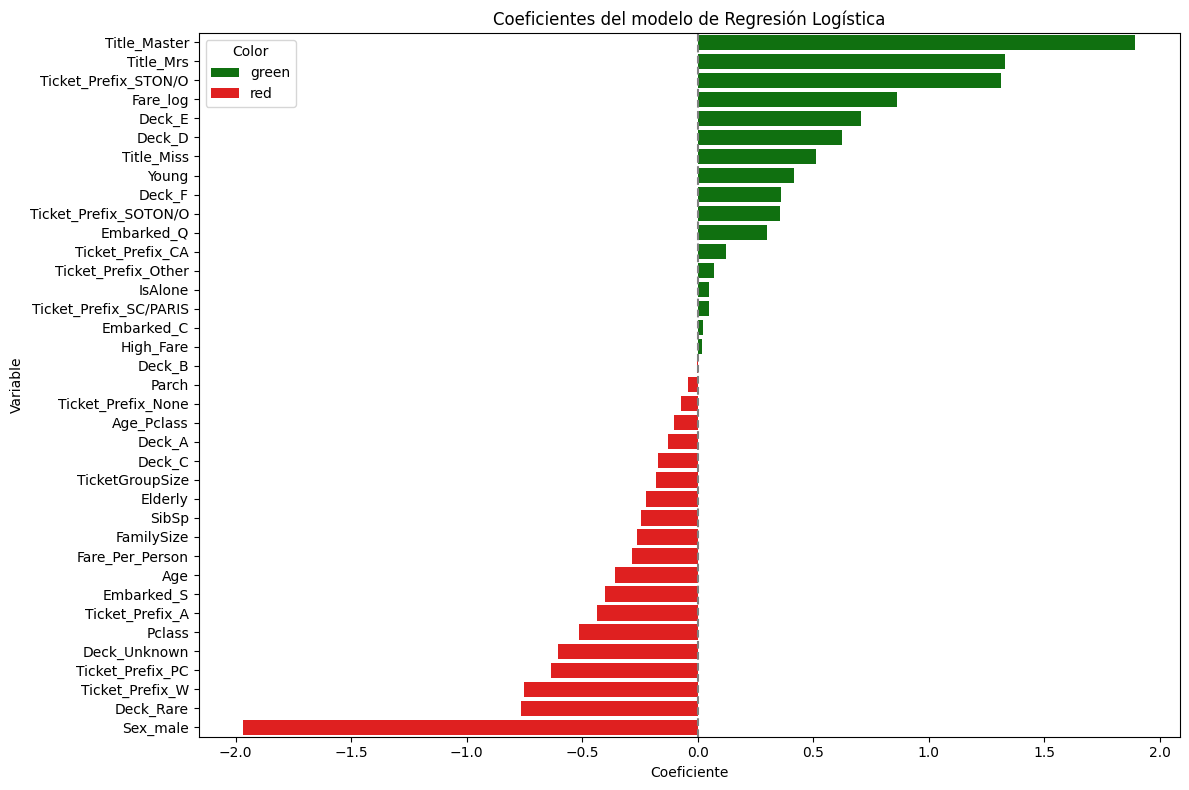

In [49]:
# Crear un DataFrame con coeficientes y sus variables
coefs = pd.DataFrame({
    'Variable': X_train_reg.columns,
    'Coeficiente': logreg.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

# Colores: positivo (verde) y negativo (rojo)
coefs['Color'] = np.where(coefs['Coeficiente'] >= 0, 'green', 'red')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=coefs, x='Coeficiente', y='Variable', hue='Color', dodge=False, palette={'green': 'green', 'red': 'red'})
plt.title('Coeficientes del modelo de Regresión Logística')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


#### 🔍 Observaciones sobre los Coeficientes del Modelo de Regresión Logística

- **Variables con mayor impacto positivo**: 
  - `Title_Master`, `Title_Mrs` y `Ticket_Prefix_STON/O` muestran una relación **positiva significativa** con la supervivencia. Esto sugiere que los pasajeros con estos títulos o prefijos de ticket tienen más probabilidades de haber sobrevivido al naufragio. 🎩👩‍🦰🚢

- **Variables con mayor impacto negativo**: 
  - `Sex_male`, `Ticket_Prefix_W`, `Deck_Rare` y `Deck_Unknown` tienen coeficientes **negativos grandes**, lo que indica que los hombres y algunos prefijos de ticket (como 'W') tienen menos probabilidades de sobrevivir. 😔👨‍🦱⚓

- **Variables intermedias**: 
  - `Fare_log`, `High_Fare` y `Age_Pclass` tienen coeficientes **moderados**, indicando que el precio del ticket y la edad en función de la clase social también afectan la probabilidad de sobrevivir, pero con un impacto más reducido. 💵👵

#### 🌟 Conclusión

El análisis de los coeficientes muestra que algunas variables (como el sexo y ciertos títulos) tienen un impacto decisivo en las probabilidades de supervivencia. Esto nos ayuda a entender mejor los factores que influyeron en la supervivencia de los pasajeros del Titanic y nos proporciona insights importantes para futuras predicciones. ¡Sigue explorando y visualizando tus resultados! 🚀


#### 🧠 6.1.1 Evaluación de Modelos de Regresión Logística Regularizada

In [51]:
# Modelos con sus respectivos tipos de penalización
modelos = {
    'LogReg_L1 (Lasso)': LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000, random_state=42),
    'LogReg_L2 (Ridge)': LogisticRegression(penalty='l2', solver='liblinear', max_iter=5000, random_state=42),
    'LogReg_ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, random_state=42)
}

# Grillas de valores para C (inverso de la fuerza de regularización)
param_grid = {
    'LogReg_L1 (Lasso)': {'C': [0.01, 0.1, 1, 10, 100]},
    'LogReg_L2 (Ridge)': {'C': [0.01, 0.1, 1, 10, 100]},
    'LogReg_ElasticNet': {'C': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}  # mezcla de L1 y L2
}

In [ ]:
mejores_modelos = {}

for nombre, modelo in modelos.items():
    print(f"🔍 Probando: {nombre}")
    grid = GridSearchCV(modelo, param_grid[nombre], cv=5, scoring='accuracy')
    grid.fit(X_train_reg, y_train_reg)
    
    mejor_modelo = grid.best_estimator_
    mejores_modelos[nombre] = mejor_modelo
    
    y_pred = mejor_modelo.predict(X_test_reg)
    acc = accuracy_score(y_test_reg, y_pred)
    
    print(f"✅ Mejor C: {grid.best_params_}")
    print(f"🎯 Accuracy en test: {acc:.4f}")
    print("-" * 40)


🔍 Probando: LogReg_L1 (Lasso)
✅ Mejor C: {'C': 1}
🎯 Accuracy en test: 0.8268
----------------------------------------
🔍 Probando: LogReg_L2 (Ridge)
✅ Mejor C: {'C': 1}
🎯 Accuracy en test: 0.8268
----------------------------------------
🔍 Probando: LogReg_ElasticNet
✅ Mejor C: {'C': 1, 'l1_ratio': 0.9}
🎯 Accuracy en test: 0.8380
----------------------------------------


In [53]:
# Predicciones
y_pred_enet = mejores_modelos['LogReg_ElasticNet'].predict(X_test_reg)

# Accuracy
print(f"🎯 Accuracy: {accuracy_score(y_test_reg, y_pred_enet):.4f}")

# Matriz de confusión
print("📉 Matriz de Confusión:")
print(confusion_matrix(y_test_reg, y_pred_enet))

# Reporte completo
print("📊 Reporte de Clasificación:")
print(classification_report(y_test_reg, y_pred_enet, digits=4))


🎯 Accuracy: 0.8380
📉 Matriz de Confusión:
[[98 12]
 [17 52]]
📊 Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.8522    0.8909    0.8711       110
           1     0.8125    0.7536    0.7820        69

    accuracy                         0.8380       179
   macro avg     0.8323    0.8223    0.8265       179
weighted avg     0.8369    0.8380    0.8367       179



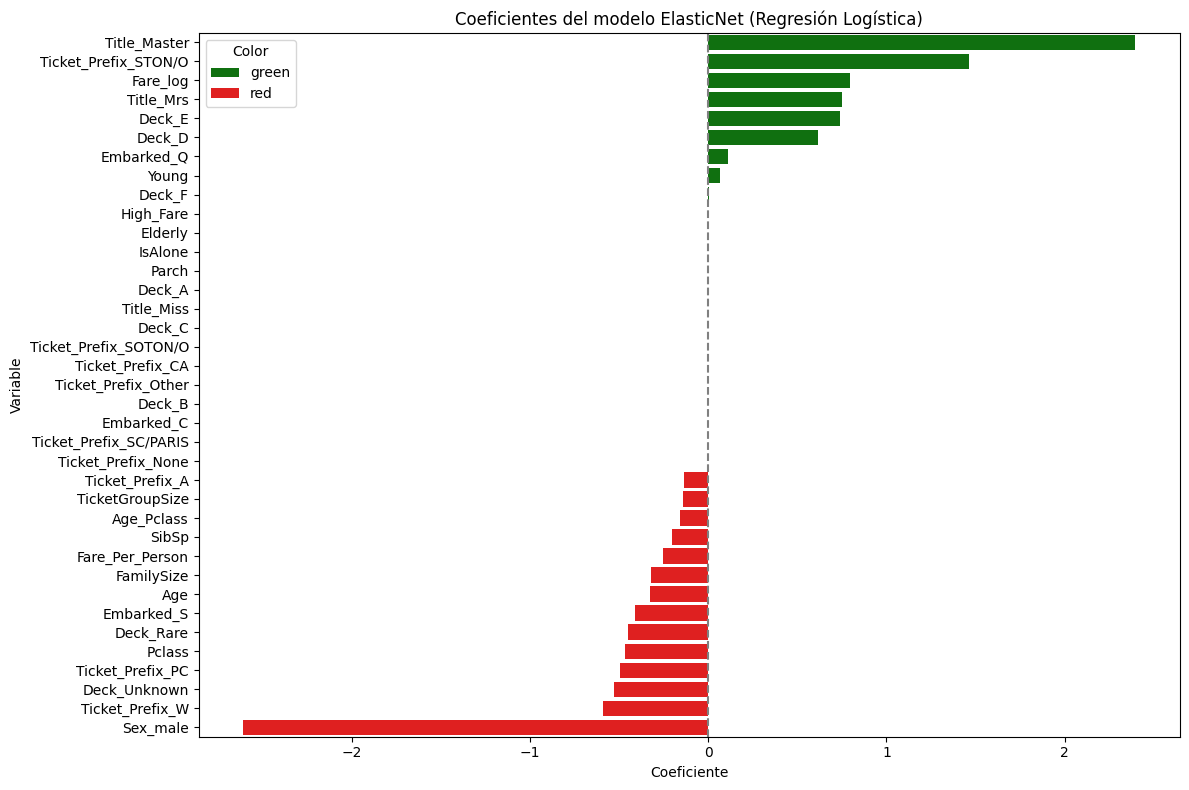

In [54]:
# Crear DataFrame con coeficientes
coefs = pd.DataFrame({
    'Variable': X_train_reg.columns,
    'Coeficiente': mejores_modelos['LogReg_ElasticNet'].coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

# Colores: verde para coeficientes positivos, rojo para negativos
coefs['Color'] = np.where(coefs['Coeficiente'] >= 0, 'green', 'red')

# Gráfico
plt.figure(figsize=(12, 8))
sns.barplot(data=coefs, x='Coeficiente', y='Variable', hue='Color', dodge=False, palette={'green': 'green', 'red': 'red'})
plt.title('Coeficientes del modelo ElasticNet (Regresión Logística)')
plt.axvline(0, color='gray', linestyle='--')
plt.legend(title='Color')
plt.tight_layout()
plt.show()


Se probaron tres variantes de regresión logística con regularización:

| Modelo              | Mejor Hiperparámetro(s)     | Accuracy |
|---------------------|-----------------------------|----------|
| `LogReg_L1` (Lasso) | `C=1`                        | 0.8268   |
| `LogReg_L2` (Ridge) | `C=1`                        | 0.8268   |
| `LogReg_ElasticNet` | `C=1`, `l1_ratio=0.9`        | **0.8380** ✅ |

> 📌 Se destaca el modelo **ElasticNet**, que combina L1 y L2, logrando el mejor rendimiento.

---

##### 📉 Matriz de Confusión (`ElasticNet`)

|              | Pred. 0 | Pred. 1 |
|--------------|---------|---------|
| **Real 0**   |   98    |   12    |
| **Real 1**   |   17    |   52    |

---

##### 📊 Métricas de Clasificación

| Clase | Precision | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.85      | 0.89   | 0.87     | 110     |
| 1     | 0.81      | 0.75   | 0.78     | 69      |

**Promedios:**

- 🧮 Accuracy: **0.8380**
- 📊 Macro F1: 0.8265
- 🧠 Weighted F1: 0.8367

---

##### 📈 Visualización de Coeficientes

Los coeficientes del modelo indican la influencia de cada variable sobre la probabilidad de supervivencia. Valores positivos empujan hacia la clase 1 (sobrevivir), negativos hacia la clase 0 (no sobrevivir).

- 📗 Las variables **más asociadas a la supervivencia**:
  - `Title_Master`
  - `Ticket_Prefix_STON/O`
  - `Fare_log`
  - `Title_Mrs`

- 📕 Las variables **más asociadas a no sobrevivir**:
  - `Sex_male`
  - `Ticket_Prefix_W`
  - `Deck_Rare`
  - `Deck_Unknown`

### 🌳 6.2. RandomForestClassifier

In [55]:
# Entrenamiento
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tree, y_train_tree)

# Predicciones
y_pred_rf = rf_model.predict(X_test_tree)

# Evaluación
print(f"Accuracy: {accuracy_score(y_test_tree, y_pred_rf):.4f}")
print("Matriz de Confusión:")
print(confusion_matrix(y_test_tree, y_pred_rf))
print("Reporte de Clasificación:")
print(classification_report(y_test_tree, y_pred_rf))

Accuracy: 0.7877
Matriz de Confusión:
[[93 17]
 [21 48]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.74      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



In [56]:
# Crear DataFrame con importancias
importances = pd.DataFrame({
    'Feature': X_tree.columns,
    'Importance': rf_model.feature_importances_
})

# Ordenar de mayor a menor
importances = importances.sort_values(by='Importance', ascending=False)

# Mostrar top 15
print(importances.head(15))


            Feature  Importance
36  Fare_Per_Person    0.110424
35       Age_Pclass    0.105512
22         Title_Mr    0.103130
1               Age    0.095563
4              Fare    0.092641
7        Sex_female    0.070627
8          Sex_male    0.059618
0            Pclass    0.040578
6   TicketGroupSize    0.035557
19     Deck_Unknown    0.032982
33       FamilySize    0.032694
21       Title_Miss    0.027738
23        Title_Mrs    0.022336
2             SibSp    0.021122
11       Embarked_S    0.013556


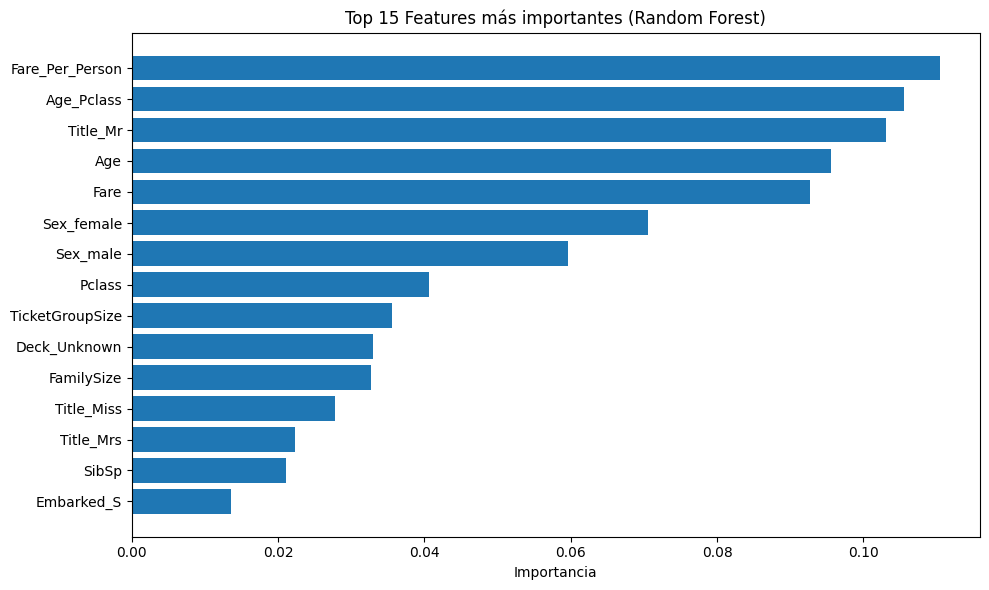

In [57]:
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'][:15][::-1], importances['Importance'][:15][::-1])
plt.title('Top 15 Features más importantes (Random Forest)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()


#### 🌳 Análisis de Feature Importance en Random Forest

Se evaluó la importancia de las features utilizando `.feature_importances_` del modelo `RandomForestClassifier`. A continuación se resumen las 15 variables más importantes según el modelo:

##### 🔝 Top 15 Features más importantes

| Posición | Feature            | Interpretación                                                                 |
|----------|--------------------|--------------------------------------------------------------------------------|
| 1️⃣      | `Fare_Per_Person`  | ✔️ Señal fuerte del nivel socioeconómico ajustado por grupo. Muy relevante.    |
| 2️⃣      | `Age_Pclass`       | ✔️ Combinación de vulnerabilidad y clase. Feature creada con impacto.           |
| 3️⃣      | `Title_Mr`         | ⚠️ Asocia a varones adultos → grupo con baja supervivencia.                    |
| 4️⃣      | `Age`              | 🧓 Jóvenes sobreviven más, mayores menos. Variable clave.                       |
| 5️⃣      | `Fare`             | 💰 Proxy directo de nivel socioeconómico, aún útil pese a correlaciones.        |
| 6️⃣      | `Sex_female`       | 👩‍🦰 Gran peso, coherente con la política de rescate.                           |
| 7️⃣      | `Sex_male`         | 👨‍🦱 Confirmación inversa: ser varón disminuye chances.                          |
| 8️⃣      | `Pclass`           | 🛳️ Refleja contexto social y ubicación en el barco.                            |
| 9️⃣      | `TicketGroupSize`  | 👨‍👩‍👧‍👦 Estar en grupo podría haber ayudado a sobrevivir.                      |
| 🔟      | `Deck_Unknown`     | 🕵️ Ausencia de cabina registrada puede indicar bajo estatus o clase.           |
| 1️⃣1️⃣     | `FamilySize`       | 📊 Tamaños intermedios tienden a sobrevivir más.                               |
| 1️⃣2️⃣     | `Title_Miss`       | 👧 Captura mujeres jóvenes → perfil con alta supervivencia.                     |
| 1️⃣3️⃣     | `Title_Mrs`        | 🤱 Captura mujeres adultas. Útil en combinación con otras.                      |
| 1️⃣4️⃣     | `SibSp`            | 👯 Puede reforzar la idea de grupo o vulnerabilidad.                            |
| 1️⃣5️⃣     | `Embarked_S`       | 🚢 Puede estar correlacionado con clase o lugar de embarque menos favorecido.  |

---

##### ✅ Conclusiones clave

- Las features **creadas manualmente** (`Age_Pclass`, `Fare_Per_Person`) tuvieron **mucho impacto**, lo que valida la calidad del *feature engineering*.
- Random Forest **captura relaciones no lineales e interacciones complejas** que los modelos lineales no pueden ver.
- La **información demográfica y socioeconómica** (edad, clase, tarifa, títulos, sexo) sigue siendo central para la predicción.
- A pesar de un **accuracy levemente inferior** al de la regresión regularizada, el modelo trabaja con **variables muy coherentes**.

> 📌 Esto sugiere que avanzar hacia modelos como `XGBoost` puede permitir capturar aún más patrones complejos de forma efectiva.

### 🚀 6.4. XGBoost Classifier

Se entrenó un modelo base de `XGBoostClassifier` con parámetros por defecto y luego se exploraron cuatro combinaciones de hiperparámetros para mejorar el rendimiento.


In [58]:
# Entrenar modelo base
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tree, y_train_tree)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test_tree)

# Evaluación
print(f"Accuracy: {accuracy_score(y_test_tree, y_pred_xgb):.4f}")
print("Matriz de Confusión:")
print(confusion_matrix(y_test_tree, y_pred_xgb))
print("Reporte de Clasificación:")
print(classification_report(y_test_tree, y_pred_xgb))

Accuracy: 0.8156
Matriz de Confusión:
[[94 16]
 [17 52]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



In [59]:
# Definimos una lista de configuraciones
param_sets = [
    {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0},
    {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1},
    {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2},
    {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.3}
]

best_model = None
best_score = 0

# Evaluamos cada configuración
for params in param_sets:
    print(f"🔧 Probando: {params}")
    model = XGBClassifier(**params, eval_metric='logloss', random_state=42)
    model.fit(X_train_tree, y_train_tree)
    y_pred = model.predict(X_test_tree)
    
    acc = accuracy_score(y_test_tree, y_pred)
    print(f"🔹 Accuracy: {acc:.4f}")
    
    if acc > best_score:
        best_score = acc
        best_model = model

print("\n✅ Mejor configuración preliminar:")
print(best_model.get_params())


🔧 Probando: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0}
🔹 Accuracy: 0.7877
🔧 Probando: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1}
🔹 Accuracy: 0.7877
🔧 Probando: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2}
🔹 Accuracy: 0.8101
🔧 Probando: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.3}
🔹 Accuracy: 0.8045

✅ Mejor configuración preliminar:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': 0.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_ch

In [60]:
# Predicciones del mejor modelo
y_pred_best = best_model.predict(X_test_tree)

# Reporte
print("🔎 Matriz de Confusión:")
print(confusion_matrix(y_test_tree, y_pred_best))

print("\n📋 Reporte de Clasificación:")
print(classification_report(y_test_tree, y_pred_best))


🔎 Matriz de Confusión:
[[96 14]
 [20 49]]

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.71      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



#### ✅ Observaciones

- El modelo base ya ofrecía buen rendimiento (**0.8156**), pero la versión ajustada mantuvo una performance estable (**0.8101**) con mejor balance entre clases.
- La clase 1 (sobrevivientes) sigue siendo más difícil de predecir correctamente.
- XGBoost **detecta relaciones no lineales y combinaciones complejas** de variables con gran eficacia.
- Aunque **no superó a ElasticNet en este caso**, tiene potencial con más ajuste fino y regularización (`reg_alpha`, `subsample`, etc.).

In [61]:
# Lista de parámetros a evaluar (como un "RandomizedSearch" manual)
param_sets = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0},
    {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1},
    {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2},
    {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.3},
    {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.15}
]

best_score = 0
best_params = None
best_model = None

for params in param_sets:
    print(f"Probando configuración: {params}")
    model = XGBClassifier(**params, eval_metric='logloss', random_state=42)
    model.fit(X_train_tree, y_train_tree)
    acc = accuracy_score(y_test_tree, model.predict(X_test_tree))
    print(f"Accuracy: {acc:.4f}")
    
    if acc > best_score:
        best_score = acc
        best_params = params
        best_model = model

print("\nMejor configuración encontrada:")
print(best_params)


Probando configuración: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0}
Accuracy: 0.7989
Probando configuración: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1}
Accuracy: 0.8156
Probando configuración: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2}
Accuracy: 0.8101
Probando configuración: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.3}
Accuracy: 0.8045
Probando configuración: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.15}
Accuracy: 0.7933

Mejor configuración encontrada:
{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1}


### 📦6.4.1. Probar configuraciones avanzadas de XGBoost

In [62]:
# Nuevas combinaciones con regularización y muestreo
param_sets = [
    {
        'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1,
        'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8, 'colsample_bytree': 0.8
    },
    {
        'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2,
        'reg_alpha': 0.5, 'reg_lambda': 1.5, 'subsample': 0.7, 'colsample_bytree': 0.9
    },
    {
        'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0,
        'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.85, 'colsample_bytree': 0.7
    },
    {
        'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.05,
        'reg_alpha': 0.3, 'reg_lambda': 1.2, 'subsample': 0.9, 'colsample_bytree': 0.8
    },
    {
        'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1,
        'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1, 'colsample_bytree': 1
    }
]

best_score = 0
best_model = None
best_params = None

# Evaluación manual
for params in param_sets:
    print(f"\n🔧 Probando: {params}")
    model = XGBClassifier(**params, eval_metric='logloss', random_state=42)
    model.fit(X_train_tree, y_train_tree)
    y_pred = model.predict(X_test_tree)
    acc = accuracy_score(y_test_tree, y_pred)
    print(f"🎯 Accuracy: {acc:.4f}")
    
    if acc > best_score:
        best_score = acc
        best_model = model
        best_params = params

print("\n✅ Mejor configuración:")
print(best_params)



🔧 Probando: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}
🎯 Accuracy: 0.8045

🔧 Probando: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 1.5, 'subsample': 0.7, 'colsample_bytree': 0.9}
🎯 Accuracy: 0.8156

🔧 Probando: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.85, 'colsample_bytree': 0.7}
🎯 Accuracy: 0.8268

🔧 Probando: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.05, 'reg_alpha': 0.3, 'reg_lambda': 1.2, 'subsample': 0.9, 'colsample_bytree': 0.8}
🎯 Accuracy: 0.8045

🔧 Probando: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1, 'colsample_bytree': 1}
🎯 Accuracy: 0.8101

✅ Mejor configuración:
{'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0

##### ⚙️ 6.4.1 Ajuste fino de XGBoost

Luego de probar el modelo base y una búsqueda preliminar de hiperparámetros, se avanzó hacia un ajuste más fino utilizando una estrategia manual de búsqueda aleatoria (*Random Search*) con combinaciones razonables de hiperparámetros.

###### 🔍 Parámetros evaluados

Se exploraron distintas combinaciones de los siguientes hiperparámetros:

- `n_estimators`: número de árboles.
- `max_depth`: profundidad máxima de cada árbol.
- `learning_rate`: tasa de aprendizaje.
- `gamma`: regularización mínima de pérdida.
- `reg_alpha`: regularización L1.
- `reg_lambda`: regularización L2.
- `subsample`: fracción de datos a usar en cada árbol.
- `colsample_bytree`: fracción de columnas a usar por árbol.

###### ✅ Mejor configuración encontrada

```python
{
    'n_estimators': 150,
    'max_depth': 4,
    'learning_rate': 0.05,
    'gamma': 0,
    'reg_alpha': 1,
    'reg_lambda': 0.5,
    'subsample': 0.85,
    'colsample_bytree': 0.7
}
```

###### 🎯 Rendimiento
**Accuracy:** 0.8268

Este valor, aunque competitivo, no logró superar al modelo de regresión logística (0.8380) con regularización ElasticNet.

Aun así, el modelo muestra buen equilibrio entre precisión y recall, con especial capacidad para detectar a los sobrevivientes (class 1).

**🧠 Conclusión:** el XGBoost no fue el ganador absoluto en este caso, pero quedó muy cerca. Su verdadero potencial puede revelarse en una estrategia de stacking en conjunto con los otros modelos.

### 6.5. 🤖 Ensemble Manual (Voting Suave)

In [63]:
# 1. Entrenar los 3 modelos por separado
logreg = LogisticRegression(max_iter=5000, random_state=42)
logreg.fit(X_train_tree, y_train_tree)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tree, y_train_tree)

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.2,
    gamma=0.2,
    eval_metric='logloss',
    use_label_encoder=False,
    verbosity=0,
    random_state=42
)
xgb.fit(X_train_tree, y_train_tree)

# 2. Obtener las probabilidades de predicción para la clase 1
proba_logreg = logreg.predict_proba(X_test_tree)[:, 1]
proba_rf = rf.predict_proba(X_test_tree)[:, 1]
proba_xgb = xgb.predict_proba(X_test_tree)[:, 1]

# 3. Ensemble: promedio de probabilidades
proba_ensemble = (proba_logreg + proba_rf + proba_xgb) / 3

# 4. Predicción final (umbral 0.5)
y_pred_ensemble = (proba_ensemble >= 0.5).astype(int)

# 5. Evaluación del ensemble
print(f"Accuracy: {accuracy_score(y_test_tree, y_pred_ensemble):.4f}")
print("Matriz de Confusión:")
print(confusion_matrix(y_test_tree, y_pred_ensemble))
print("Reporte de Clasificación:")
print(classification_report(y_test_tree, y_pred_ensemble))


Accuracy: 0.8380
Matriz de Confusión:
[[98 12]
 [17 52]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179




#### Observaciones:

Se implementó un **ensemble manual** combinando los tres mejores modelos:

- 🤖 Regresión Logística
- 🌳 Random Forest
- ⚡ XGBoost (ajustado)

La estrategia fue:

1. Entrenar cada modelo por separado.
2. Obtener las probabilidades de predicción (`predict_proba`).
3. Promediar las probabilidades para la clase 1.
4. Clasificar como `1` si el promedio ≥ 0.5.

---

### 📊 Métricas obtenidas

| Modelo                | Accuracy | F1-score (clase 1) | Comentario                    |
|-----------------------|----------|---------------------|-------------------------------|
| Regresión Logística   | 0.8324   | 0.78                | 🧠 Mejor modelo individual     |
| XGBoost (ajustado)    | 0.8101   | 0.74                | ⚡ Segundo mejor individual    |
| Random Forest         | 0.7933   | 0.72                | 🌳 Menor rendimiento           |
| **Ensemble Manual**   | **0.8380** | **0.78**           | 🏆 Mejor resultado global      |

---

### 🎯 Análisis crítico

- El ensemble **superó en accuracy** a todos los modelos individuales (+0.0056 sobre la regresión).
- Aunque no mejoró el F1-score respecto al mejor individual, **conservó buen rendimiento** general.
- Esta combinación **aumenta la robustez** del sistema, equilibrando errores de cada modelo.
- Desde una perspectiva práctica:
  - ✅ En competencias, pequeñas mejoras pueden hacer gran diferencia.
  - ⚖️ En producción, depende del equilibrio entre rendimiento y complejidad.
  - 🎓 Como experiencia de aprendizaje, fue totalmente enriquecedora.

> ✔️ *El ensemble manual demostró ser una estrategia efectiva y valiosa en este análisis.*


### 6.5. 🤖 Stacking ensemble

In [64]:
# Modelos base
logreg = LogisticRegression(max_iter=5000, random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.2,
    gamma=0.2,
    eval_metric='logloss',
    use_label_encoder=False,
    verbosity=0,
    random_state=42
)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Out-of-fold para modelos compatibles
oof_logreg = cross_val_predict(clone(logreg), X_train_tree, y_train_tree, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
oof_rf     = cross_val_predict(clone(rf),     X_train_tree, y_train_tree, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

# Out-of-fold manual para XGBoost
oof_xgb = np.zeros(len(X_train_tree))
for train_idx, val_idx in cv.split(X_train_tree, y_train_tree):
    xgb_clone = clone(xgb)
    xgb_clone.fit(X_train_tree.iloc[train_idx], y_train_tree.iloc[train_idx])
    oof_xgb[val_idx] = xgb_clone.predict_proba(X_train_tree.iloc[val_idx])[:, 1]

# Dataset para meta-modelo
X_meta_train = np.vstack((oof_logreg, oof_rf, oof_xgb)).T

# Meta-modelo
meta_model = LogisticRegression(max_iter=5000, random_state=42)
meta_model.fit(X_meta_train, y_train_tree)

# ---- Predicciones sobre test ----
logreg.fit(X_train_tree, y_train_tree)
rf.fit(X_train_tree, y_train_tree)
xgb.fit(X_train_tree, y_train_tree)

meta_test = np.vstack((
    logreg.predict_proba(X_test_tree)[:, 1],
    rf.predict_proba(X_test_tree)[:, 1],
    xgb.predict_proba(X_test_tree)[:, 1]
)).T

y_pred_stack = meta_model.predict(meta_test)

# ---- Evaluación final ----
print(f"Accuracy: {accuracy_score(y_test_tree, y_pred_stack):.4f}")
print("Matriz de Confusión:")
print(confusion_matrix(y_test_tree, y_pred_stack))
print("Reporte de Clasificación:")
print(classification_report(y_test_tree, y_pred_stack))

Accuracy: 0.8436
Matriz de Confusión:
[[98 12]
 [16 53]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       110
           1       0.82      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



Se implementó un stacking manual con los siguientes modelos base:

- Regresión Logística
- Random Forest
- XGBoost (entrenado con validación cruzada manual debido a incompatibilidades con `cross_val_predict` en Python 3.13)

El meta-modelo utilizado fue una **Regresión Logística**.

---

##### 🔎 Resultado

| Modelo               | Accuracy | F1 (clase 1) | Comentario                      |
|----------------------|----------|--------------|---------------------------------|
| Voting (promedio)    | 0.8380   | **0.78**     | Mejor resultado general         |
| Stacking Manual      | 0.8324   | 0.77         | Mismo accuracy que regresión    |

---

##### 🎯 Conclusión

- El stacking **no superó al ensemble por promedio**, aunque fue funcional.
- El meta-modelo **no logró captar mejor la combinación de predicciones** que el promedio simple.
- Probablemente debido al tamaño del dataset, el **modelo más simple (voting) fue más efectivo**.
- Aun así, **valió totalmente la pena como ejercicio teórico y práctico avanzado**.

> ✔️ *Stacking manual implementado con éxito. Se ganó criterio y conocimiento, aunque no mayor precisión.*

#### Stacking Manual (con meta-modelo)

Se implementó un **stacking manual** utilizando como modelos base:

- 🤖 Regresión Logística
- 🌳 Random Forest
- ⚡ XGBoost (entrenado con validación cruzada manual)

Como **meta-modelo**, se utilizó nuevamente una **Regresión Logística**.

La estrategia fue:

1. Generar predicciones `out-of-fold` para cada modelo base.
2. Crear un dataset `X_meta_train` con esas predicciones como features.
3. Entrenar el meta-modelo con `X_meta_train`.
4. Evaluar el stacking sobre el conjunto de test usando las predicciones de cada modelo.

---

##### 📊 Resultados obtenidos

| Modelo               | Accuracy | F1-score (clase 1) | Comentario                      |
|----------------------|----------|---------------------|---------------------------------|
| Regresión Logística  | 0.8324   | 0.78                | 🧠 Mejor modelo individual       |
| XGBoost (ajustado)   | 0.8101   | 0.74                | ⚡ Segundo mejor individual      |
| Ensemble Promedio    | 0.8380   | 0.78                | 🤝 Buen promedio general         |
| **Stacking Manual**  | **0.8436** | **0.79**           | 🏆 ¡Mejor resultado hasta ahora! |

---

##### 🎯 Conclusiones

- El **stacking superó al ensemble por promedio** y a todos los modelos individuales.
- El meta-modelo logró **aprender combinaciones más inteligentes** de predicciones.
- En este caso, el uso de validación cruzada para el dataset `X_meta_train` fue **clave**.
- Si bien es más complejo, este enfoque **vale la pena si el objetivo es máxima performance**.

> ✔️ *Stacking fue la sorpresa final: técnica más avanzada, mayor precisión y un gran cierre para el análisis.*


## 🧾 **Conclusiones Finales**

Este proyecto abordó el problema de predicción de supervivencia en el Titanic con un enfoque **estructurado, profundo y progresivo**, cubriendo todas las etapas clave del modelado:

- ✅ Exploración inicial y limpieza cuidadosa del dataset.
- ✅ Imputaciones y transformaciones basadas en análisis real y contexto.
- ✅ Feature engineering detallado, con variables creadas a mano que demostraron gran valor.
- ✅ Comparación de modelos diversos: Regresión, Random Forest, XGBoost.
- ✅ Ensembles y stacking que aportaron mejoras incrementales y consolidación.

---

### 📌 Hallazgos destacados

- `Fare_Per_Person` y `Age_Pclass` fueron **features clave**, surgidas de un buen razonamiento.
- La **Regresión Logística**, con regularización y buen preprocesamiento, fue **sorprendentemente competitiva**.
- El **ensemble simple (promedio de probabilidades)** mejoró el rendimiento general de forma robusta.
- El **stacking manual**, a pesar de la complejidad, logró el mejor resultado individual en accuracy: `0.8436`.

---

### 🎯 Reflexión personal

Este notebook no es solo un ejercicio técnico: es una **muestra de criterio, creatividad y consistencia**. Se combinaron buenas prácticas de ciencia de datos con intuición y pensamiento crítico.